In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, precision_score, recall_score, median_absolute_error, mean_absolute_error,mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert import modeling_bert

# Functions used in all training notebooks

In [2]:
# Function to map hexbin plot colors
def my_reduce(x):
    npsum = np.sum(x)
    return np.log(npsum)


# Function to train model (1 epoch)
def train_model(model,input_function, train_loader, criterion, optimizer, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train() # enable train mode
    running_loss = 0.0
    
    if verbose == 2:
        status = train_loader
    else:
        status = tqdm_notebook(train_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(*input_tensors)
        loss = criterion(torch.squeeze(outputs).to(torch.float32),labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose !=2:
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 batches
                tqdm.write(f'Batch {i + 1:5d}    Loss: {running_loss / 500:.5f}')
                running_loss = 0.0

                
# Function to test model            
def test_model(model,input_function, test_loader, criterion, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval() # enable evaluation mode
    valid_loss = 0
    valid_preds, valid_labels = [], []
    
    if verbose == 2:
        status = test_loader
    else:
        status = tqdm_notebook(test_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists: [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        outputs = model(*input_tensors)
        loss = criterion(outputs[0].to(torch.float32),labels.to(torch.float32))
        valid_preds.append(outputs[0].cpu().detach().item())
        valid_labels.append(labels.cpu().detach().item())
        valid_loss += loss.item()

    valid_mse = mean_squared_error(valid_labels, valid_preds)
    valid_maerr = mean_absolute_error(valid_labels, valid_preds)
    
    if verbose !=2:
        print("\nTest Results:\nLoss: {:.6f}".format(valid_loss / len(test_loader)))
        print("Total Mean Squared Error: {:.4f}".format(valid_mse))
        print("Total Mean Absolute Error: {:.4f}\n".format(valid_maerr))

        # Plots

        # Prepare Hexbin plot
        temp_df = pd.DataFrame(zip(valid_preds,valid_labels), columns = ['Predicted values', 'Hops'])
        temp_df['Hops'] = 1/temp_df['Hops']
        temp_df['C'] = 1

        if verbose:
            fig, axes = plt.subplots(4,1, figsize = (10,20))
        else:
            fig, axes = plt.subplots(2,1, figsize = (10,10))

        temp_df.plot.hexbin(ax = axes[0], x ='Hops', y='Predicted values',C = 'C', reduce_C_function=my_reduce,colormap="viridis")
        axes[0].set_title("Hexbin Plot")
    
    # Calculate metrics per Hop
    mse = []
    mae = []
    high1_p=high_close_p=high_mid_p=high_far_p=high1_n=high_close_n=high_mid_n=high_far_n=0
    for i in range(1,30):
        target = 1/i
#         target = i
        preds = []
        trues = []
        for predicted, true in zip(valid_preds, valid_labels):
            if true == target:
                preds.append(predicted)
                trues.append(true)
                if predicted > 0.5:
                    if i==1:
                        high1_p +=1
                    elif i<4:
                        high_close_p +=1
                    elif i<11:
                        high_mid_p +=1
                    else:
                        high_far_p +=1
                else:
                    if i==1:
                        high1_n +=1
                    elif i<4:
                        high_close_n +=1
                    elif i<11:
                        high_mid_n +=1
                    else:
                        high_far_n +=1
        if len(trues)==0:
            continue
        mae.append(mean_absolute_error(trues, preds))
        mse.append(mean_squared_error(trues, preds))
        if i<4 and verbose != 2:
            print(" Hop '"+str(i)+"'\tMAE: {:.4f}, MSE: {:.4f}".format(mae[i-1],mse[i-1])) 
        if i==1:
            hist_preds = preds
    if high1_n == 0: high1_n=1
    if high_close_n == 0: high_close_n=1
    if high_mid_n == 0: high_mid_n=1
    if high_far_n == 0: high_far_n=1
    p1 = high1_p*100/(high1_p+high1_n)
    p2 = high_close_p*100/(high_close_p+high_close_n)
    p3 = high_mid_p*100/(high_mid_p+high_mid_n)
    p4 = high_far_p*100/(high_far_p+high_far_n)
    tp = high1_p
    tn = high_mid_n + high_far_n
    fp = high_mid_p + high_far_p
    fn = high1_n
    if fp == 0: fp = 1
    pseudo_precision = tp/(tp + fp)
    pseudo_recall = tp/(tp + fn)
    pseudo_accuracy = (tp + tn) / (tp + fn + tn +fp)
    if pseudo_recall == 0 and pseudo_precision == 0 :
        pseudo_f1 = 0
        f1g = 0
    else:
        pseudo_f1 = 2 * pseudo_precision * pseudo_recall / (pseudo_precision + pseudo_recall)
        proportion = (high1_n + high1_p)/(high_mid_p + high_mid_n + high_far_p + high_far_n)
        print(proportion)
        f1g = (pseudo_f1 - proportion)/(pseudo_f1 * (1 - proportion))
    
    if verbose !=2:
        print("\nPercentage of prediction > 0.5: ")
        print(" Hop  1: \t{:.4f}%".format(p1))
        print(" Hops 2-3: \t{:.4f}%".format(p2))
        print(" Hops 4-10: \t{:.4f}%".format(p3))
        print(" Hops 11+: \t{:.4f}%".format(p4))
        
        print("\nPseudo binary metrics (ignoring Hops 2 & 3): ")
        print("Precision: \t{:.4f}%".format(pseudo_precision*100))
        print("Recall: \t{:.4f}%".format(pseudo_recall*100))
        print("Accuracy: \t{:.4f}%".format(pseudo_accuracy*100))
        print("f1: \t{:.4f}%".format(pseudo_f1*100))
        print("f1 Gain: \t{:.4f}%".format(f1g*100))
    
        if high1_n>1:
#             sns.histplot(hist_preds,ax = axes[1], bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3], color = 'lime')
            sns.histplot(hist_preds,ax = axes[1], color = 'lime')
        axes[1].set_title("Prediction distribution for Hop '1'")
        axes[1].grid(axis = 'y', alpha = 0.5)

        if verbose:
            axes[2].bar(range(1,len(mse)+1), mse, color = 'lightcoral')
            axes[2].set_title("Mean Squared Error per Hop")
            axes[2].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mse):
                axes[2].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)

            axes[3].bar(range(1,len(mae)+1), mae, color = 'royalblue')
            axes[3].set_title("Mean Absolute Error per Hop")
            axes[3].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mae):
                axes[3].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)
        plt.show()
   
    return {'pseudo_precision': pseudo_precision, 'pseudo_recall':pseudo_recall, 'pseudo_accuracy': pseudo_accuracy, 'pseudo_f1': pseudo_f1 ,'mse_list': mse, 'mae_list': mae, "Hop1 High": p1,'Hop2-3 High%': p2, 'Hop4-10 High%': p3, 'Hop11+ High%': p4, 'loss':(valid_loss / len(test_loader))}


def save_for_best_mse1(metrics_dict):
    return metrics_dict['mse_list'][0]

# Function to train model and test model for multiple epochs
def AIO(model, input_function, train_loader, valid_loader, EPOCHS, criterion, optimizer, scheduler,save_name, save_criterion_func = save_for_best_mse1, train_loader2 = None, verbose = False):
    try:
        os.mkdir('./'+save_name+'/') 
    except:
        if verbose != 2:
            print("Couldn't make new directory "+save_name+ ", it already exists?")
    
    # Initialize best save criterion value
    best_save_criterion = 100000000
    last_epoch = 0
    
    # Use GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Start training
    for epoch in range(1, EPOCHS+1):  # loop over the dataset multiple times
        if verbose != 2: tqdm.write("Epoch "+str(epoch))
            
        # Train
        train_model(model,input_function, train_loader, criterion, optimizer, verbose)
        
        # If subsampled train set is provided, test to monitor overfitting behaviour
        if train_loader2 is not None:
            test_model(model, input_function, train_loader2, criterion, verbose)
            
        # Test on validation dataset   
        valid_metrics = test_model(model, input_function, valid_loader, criterion, verbose)
        scheduler.step()
        
        # If validation performance is better, save model
        save_criterion = save_criterion_func(valid_metrics)
        if save_criterion < best_save_criterion:
            best_save_criterion = save_criterion
            last_epoch = epoch
            torch.save(model, save_name+'/Model.pth')
            # If the model uses a tokenizer as input, save it
            try:
                input_function.save_pretrained(save_name+'/custom_tokenizer/') 
            except:
                pass
            if verbose != 2:
                print("New best Validation! Saving weights...")
                
    if verbose == 2:
        return valid_metrics['loss'], last_epoch
    print('Finished Training')
    return valid_metrics['loss'], last_epoch

In [3]:
def inverse_transform(Hops):
    return (1/Hops)


def joining(text1, text2):
    text = text1
    text += f" [SEP] "+text2
    return text


def Load_Datasets(Dataset_version,y_transform = inverse_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.1, SubTrainPercentage = 0.1, verbose = True):
    # Load whole Train dataset
    data_train = pd.read_csv('Hops Dataset '+Dataset_version+' - A.csv', header=0)
#     data_train.drop(data_train[data_train['Hops'] == 2].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 3].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 4].index, inplace=True)
#     data_train.drop(data_train[data_train['Hops'] == 5].index, inplace=True)
    data_train = data_train[data_train["Hops"]>0]

    # Load whole Test dataset
    data_test = pd.read_csv('Hops Dataset '+Dataset_version+' - B.csv', header=0)
    data_test = data_test[data_test["Hops"]>0]
#     data_test.drop(data_test[data_test['Hops'] == 2].index, inplace=True)    
#     data_test.drop(data_test[data_test['Hops'] == 3].index, inplace=True)
#     data_test.drop(data_test[data_test['Hops'] == 4].index, inplace=True)    
#     data_test.drop(data_test[data_test['Hops'] == 5].index, inplace=True)

    # Balanced (subsampled) datasets
    data_train_balanced = data_train.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train[data_train['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    data_test_balanced = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test[data_test['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    # Validation Dataset. Initialize from data
    data_valid = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test_balanced[data_test_balanced['Hops']==1])*ValidationPercentageSplit))))
    # Remove any entry given to the validation set from the balanced test set
    data_test = data_test[~data_test.isin(data_valid)].dropna()

    # Subsampled train set to monitor overfitting behaviour
    data_sub_train = data_train_balanced.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train_balanced[data_train_balanced['Hops']==1])*SubTrainPercentage))))

    if verbose: 
        fig, axes = plt.subplots(1,2, figsize = (25,10), sharey = True, sharex = True)
        all_sns_bins = list(range(1,25))
        print("Raw Train data: "+str(data_train.shape[0])+" samples")
        sns.histplot(data_train["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Raw Train data: "+str(data_train.shape[0])+" samples")
        print("Raw Test data: "+str(data_test.shape[0])+" samples")
        sns.histplot(data_test["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Raw Test data: "+str(data_test.shape[0])+" samples")
        plt.show()

        fig, axes = plt.subplots(1,3, figsize = (25,10), sharey = True, sharex = True)
        print("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        sns.histplot(data_train_balanced["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        print("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_valid["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_test_balanced["Hops"],ax = axes[2], bins = all_sns_bins)
        axes[2].set_title("Balanced Test data - no overlap: "+str(data_test_balanced.shape[0])+" samples")
        plt.show()

    data_train_balanced["Hops"] = y_transform(data_train_balanced["Hops"])
    if verbose: print(data_train_balanced)
    y_train = pd.to_numeric(data_train_balanced.Hops)#.astype(int)
    x_train = np.vectorize(joining)(data_train_balanced.Head.astype(str),data_train_balanced.Tail.astype(str))
    if verbose: print(x_train[0])
        
    data_valid["Hops"] = y_transform(data_valid["Hops"])
    y_valid = pd.to_numeric(data_valid.Hops)#.astype(int)
    x_valid = np.vectorize(joining)(data_valid.Head.astype(str),data_valid.Tail.astype(str))

    data_sub_train["Hops"] = y_transform(data_sub_train["Hops"])
    y_sub_train = pd.to_numeric(data_sub_train.Hops)#.astype(int)
    x_sub_train = np.vectorize(joining)(data_sub_train.Head.astype(str),data_sub_train.Tail.astype(str))

    data_test_balanced["Hops"] = y_transform(data_test_balanced["Hops"])
    y_test_balanced = pd.to_numeric(data_test_balanced.Hops)#.astype(int)
    x_test_balanced = np.vectorize(joining)(data_test_balanced.Head.astype(str),data_test_balanced.Tail.astype(str))
    
    return x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced

# Load Train and Test Dataset

Raw Train data: 2027091 samples
Raw Test data: 3902132 samples


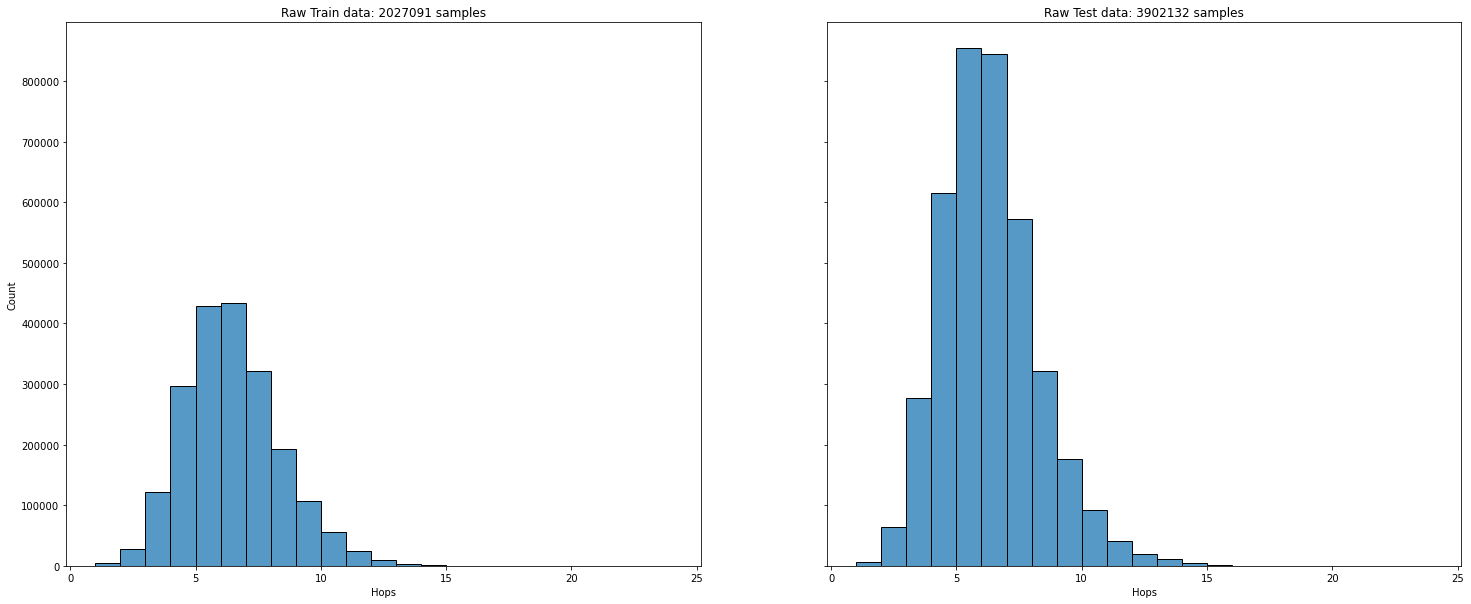

Balanced Train data: 54739 samples
Validation data: 5278 samples


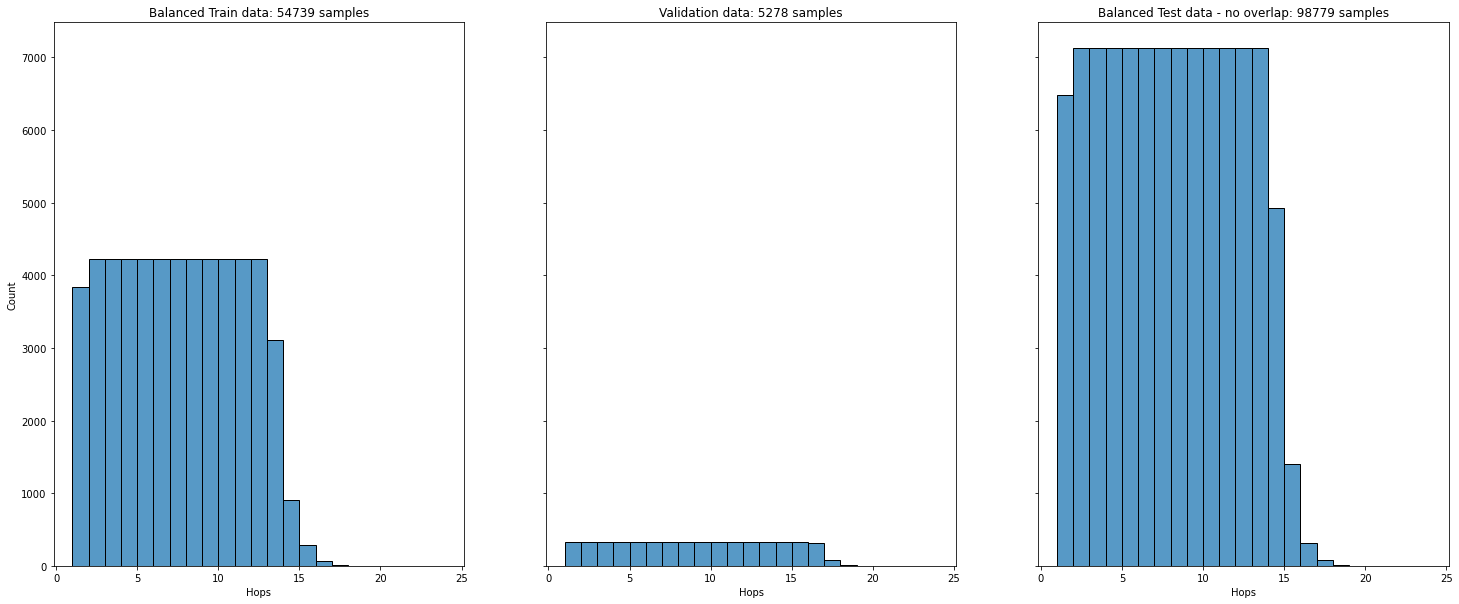

                                                      Head  \
1295279  (RefSeq) cytochrome P450 2D6-like, ytochrome P...   
1563671                             CTNNB1, catenin beta 1   
939106     1-Phosphatidyl-1D-myo-inositol 3,4-bisphosphate   
1591129     VAV3, vav guanine nucleotide exchange factor 3   
1001645                      (GlcN)1 (Ino(acyl)-P)1 (Man)2   
...                                                    ...   
828681          MOGS, mannosyl-oligosaccharide glucosidase   
299699        TM7SF2, transmembrane 7 superfamily member 2   
829643          MOGS, mannosyl-oligosaccharide glucosidase   
854291                       Dolichyl D-glucosyl phosphate   
832738       ALG10B, ALG10 alpha-1,2-glucosyltransferase B   

                                                      Tail      Hops  
1295279                                   Hydroxytamoxifen  1.000000  
1563671                            CBL, Cbl proto-oncogene  1.000000  
939106            Phosphatidylinositol-3,4

In [4]:
def squared(Hops):
    return Hops**2

def no_transform(Hops):
    return Hops

def make_binary(Hops):
    temp = 1/Hops
    return np.floor(temp)
    

y_transform = inverse_transform
# y_transform = make_binary
x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced = Load_Datasets(
     'v8',y_transform = y_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.05, SubTrainPercentage = 0.05)

# Define Model Architecture

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*768, 512), nn.ReLU(), nn.Dropout(0.1),
#             nn.Linear(1984, 1866), nn.ReLU(), nn.Dropout(0.249),
#             nn.Linear(1866, 680), nn.ReLU(), nn.Dropout(0.305),
#             nn.Linear(680,1921), nn.ReLU(), nn.Dropout(0.332),
            nn.Linear(512, 1)
            )

    def forward(self, *inputs, **args):
        logits = self.linear_relu_stack(torch.stack(list(inputs), dim=0))
        return logits
    
    
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            nn.Linear(24576, 1280), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(1280, 512), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(512, 1)
            )

    def forward(self, *inputs, **args):
        logits = self.linear_relu_stack(torch.stack(list(inputs), dim=0))
        return logits

# Load Embeddings Dictionary  
import pickle
# with open('node_embeddings_dict.pkl', 'rb') as f:
with open('node_embeddings_dict_BioBERT.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)
    
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Function to prepare input data for above model
def FE_inputs(inputs_list):
    input_embeddings = []
    for row in inputs_list:
        X_ls = row.split(' [SEP] ')
        input_embeddings.append(np.append(embeddings_dict[X_ls[0]],embeddings_dict[X_ls[1]]))
    return torch.FloatTensor(np.array(input_embeddings)).to(DEVICE)

def FE_inputs_conv2d(inputs_list):
    input_embeddings = []
    for row in inputs_list:
        X_ls = row.split(' [SEP] ')
        ch11 = np.array(embeddings_dict[X_ls[0]][0:768])
        ch12 = np.array(embeddings_dict[X_ls[0]][768:1536])
        ch13 = np.array(embeddings_dict[X_ls[0]][1536:2304])
        ch14 = np.array(embeddings_dict[X_ls[0]][2304:3072])
        ch21 = np.array(embeddings_dict[X_ls[1]][0:768])
        ch22 = np.array(embeddings_dict[X_ls[1]][768:1536])
        ch23 = np.array(embeddings_dict[X_ls[1]][1536:2304])
        ch24 = np.array(embeddings_dict[X_ls[1]][2304:3072])
        ch1 = np.append(ch11, ch21).reshape(48,32)
        ch2 = np.append(ch12, ch22).reshape(48,32)
        ch3 = np.append(ch13, ch23).reshape(48,32)
        ch4 = np.append(ch14, ch24).reshape(48,32)
        
        input_embeddings.append([ch1, ch2, ch3, ch4])
    return torch.FloatTensor(np.array(input_embeddings)).to(DEVICE)


# Hyper-parameters and Train

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)
Couldn't make new directory PubMedBERT, it already exists?
Epoch 1


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.02720
Batch  1000    Loss: 0.02473
Batch  1500    Loss: 0.02372


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.019384
Total Mean Squared Error: 0.0640
Total Mean Absolute Error: 0.2052

 Hop '1'	MAE: 0.3964, MSE: 0.1735
 Hop '2'	MAE: 0.1132, MSE: 0.0193
 Hop '3'	MAE: 0.2199, MSE: 0.0593
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	81.2500%
 Hops 2-3: 	73.4375%
 Hops 4-10: 	24.5536%
 Hops 11+: 	4.6711%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	29.1589%
Recall: 	81.2500%
Accuracy: 	83.9458%
f1: 	42.9161%
f1 Gain: 	88.3969%


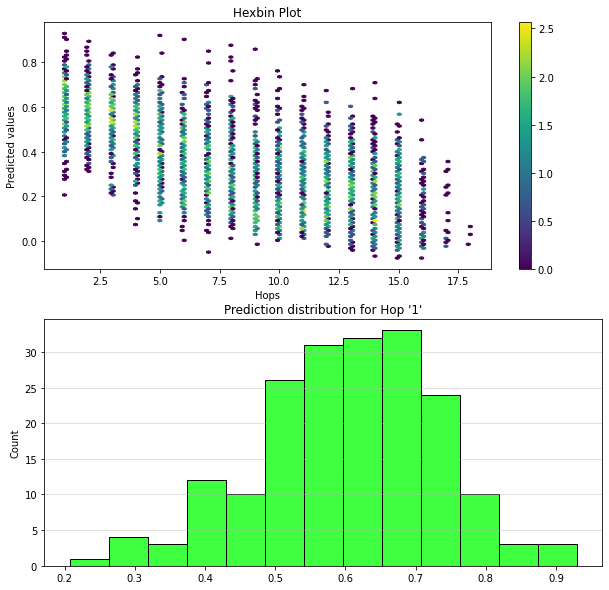

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023250
Total Mean Squared Error: 0.0797
Total Mean Absolute Error: 0.2368

 Hop '1'	MAE: 0.4726, MSE: 0.2382
 Hop '2'	MAE: 0.0942, MSE: 0.0140
 Hop '3'	MAE: 0.2021, MSE: 0.0510
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	62.3457%
 Hops 2-3: 	64.6605%
 Hops 4-10: 	25.0441%
 Hops 11+: 	9.3229%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	21.0417%
Recall: 	62.3457%
Accuracy: 	80.9935%
f1: 	31.4642%
f1 Gain: 	82.2767%


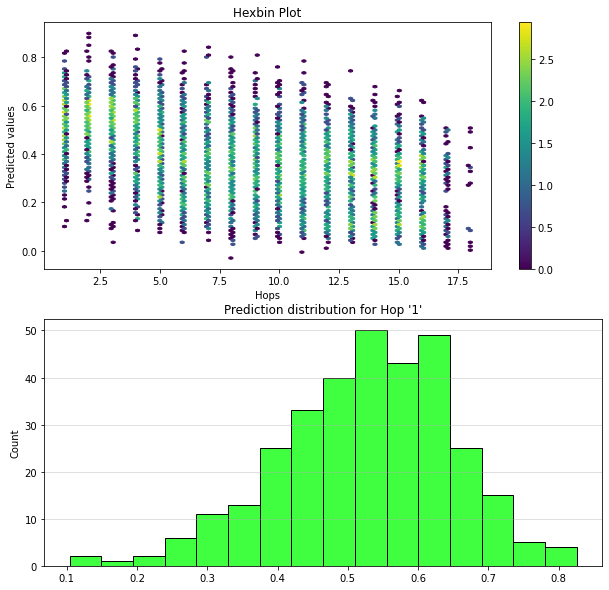

New best Validation! Saving weights...
Epoch 2


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.02310
Batch  1000    Loss: 0.02216
Batch  1500    Loss: 0.02142


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.018216
Total Mean Squared Error: 0.0522
Total Mean Absolute Error: 0.1792

 Hop '1'	MAE: 0.4004, MSE: 0.1798
 Hop '2'	MAE: 0.1181, MSE: 0.0234
 Hop '3'	MAE: 0.1980, MSE: 0.0509
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	76.5625%
 Hops 2-3: 	64.3229%
 Hops 4-10: 	15.4762%
 Hops 11+: 	2.5739%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	38.4817%
Recall: 	76.5625%
Accuracy: 	89.1683%
f1: 	51.2195%
f1 Gain: 	91.6921%


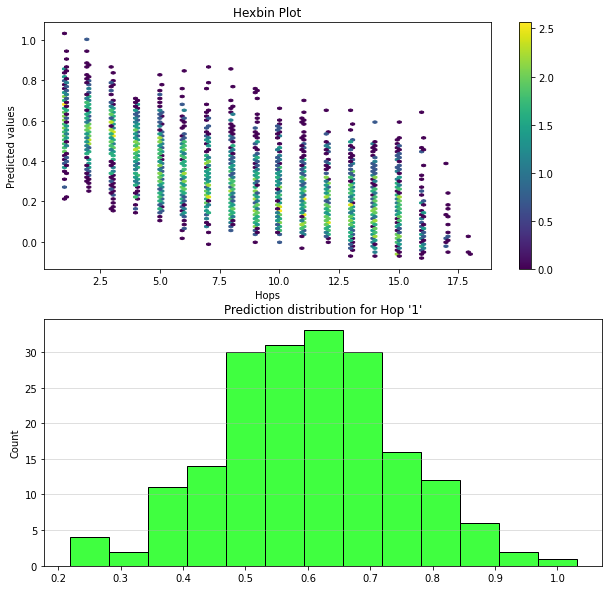

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023135
Total Mean Squared Error: 0.0700
Total Mean Absolute Error: 0.2178

 Hop '1'	MAE: 0.4930, MSE: 0.2592
 Hop '2'	MAE: 0.0912, MSE: 0.0145
 Hop '3'	MAE: 0.1712, MSE: 0.0400
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	56.4815%
 Hops 2-3: 	50.3086%
 Hops 4-10: 	19.0476%
 Hops 11+: 	5.3974%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	25.2414%
Recall: 	56.4815%
Accuracy: 	85.2484%
f1: 	34.8904%
f1 Gain: 	84.8161%


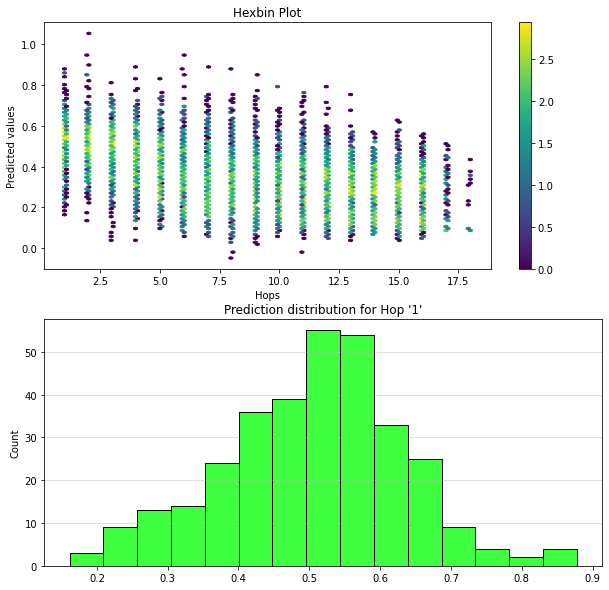

New best Validation! Saving weights...
Epoch 3


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.02130
Batch  1000    Loss: 0.02028
Batch  1500    Loss: 0.02034


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.017519
Total Mean Squared Error: 0.0563
Total Mean Absolute Error: 0.1887

 Hop '1'	MAE: 0.3485, MSE: 0.1391
 Hop '2'	MAE: 0.1524, MSE: 0.0334
 Hop '3'	MAE: 0.2646, MSE: 0.0848
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	86.9792%
 Hops 2-3: 	79.4271%
 Hops 4-10: 	21.8006%
 Hops 11+: 	3.6225%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	33.5341%
Recall: 	86.9792%
Accuracy: 	86.2282%
f1: 	48.4058%
f1 Gain: 	90.7021%


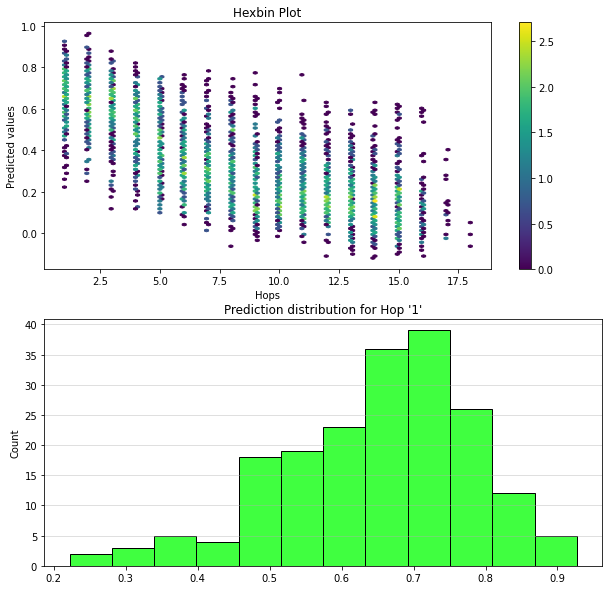

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023051
Total Mean Squared Error: 0.0816
Total Mean Absolute Error: 0.2430

 Hop '1'	MAE: 0.4564, MSE: 0.2263
 Hop '2'	MAE: 0.1152, MSE: 0.0195
 Hop '3'	MAE: 0.2234, MSE: 0.0624
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	65.7407%
 Hops 2-3: 	69.5988%
 Hops 4-10: 	24.3386%
 Hops 11+: 	9.4701%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	22.2338%
Recall: 	65.7407%
Accuracy: 	81.5119%
f1: 	33.2293%
f1 Gain: 	83.6504%


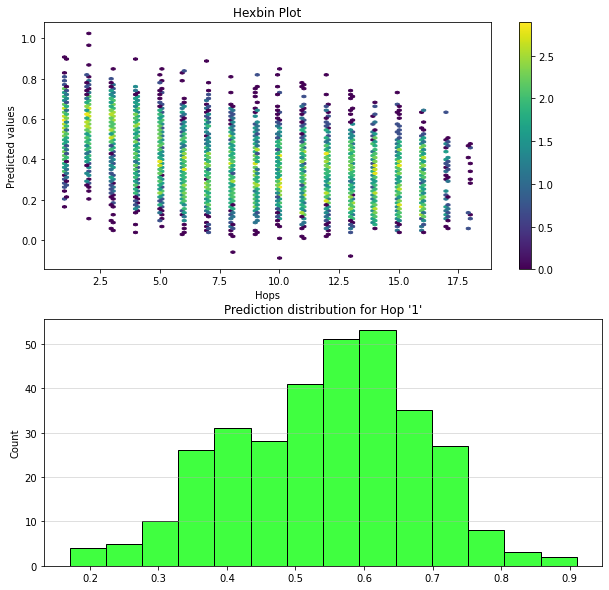

New best Validation! Saving weights...
Epoch 4


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01934
Batch  1000    Loss: 0.02002
Batch  1500    Loss: 0.01960


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.016240
Total Mean Squared Error: 0.0452
Total Mean Absolute Error: 0.1601

 Hop '1'	MAE: 0.3752, MSE: 0.1603
 Hop '2'	MAE: 0.1158, MSE: 0.0214
 Hop '3'	MAE: 0.1986, MSE: 0.0499
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	83.3333%
 Hops 2-3: 	65.6250%
 Hops 4-10: 	15.4018%
 Hops 11+: 	3.4318%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	39.7022%
Recall: 	83.3333%
Accuracy: 	89.3617%
f1: 	53.7815%
f1 Gain: 	92.5034%


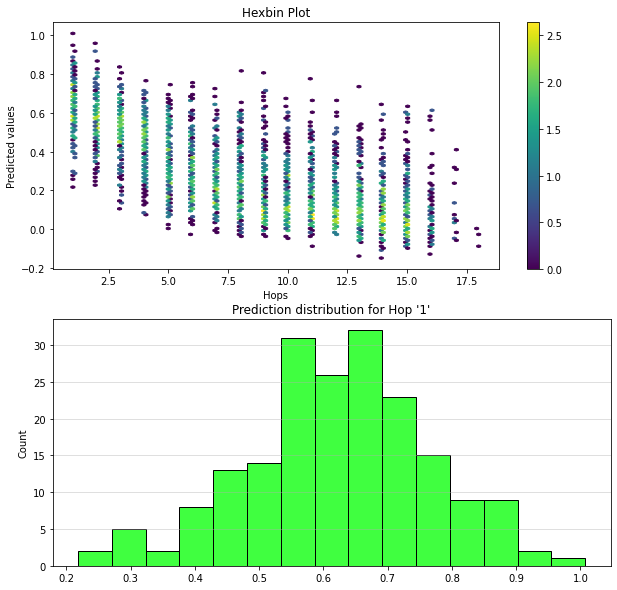

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022590
Total Mean Squared Error: 0.0668
Total Mean Absolute Error: 0.2049

 Hop '1'	MAE: 0.4890, MSE: 0.2559
 Hop '2'	MAE: 0.0936, MSE: 0.0160
 Hop '3'	MAE: 0.1739, MSE: 0.0395
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	56.4815%
 Hops 2-3: 	50.1543%
 Hops 4-10: 	18.1658%
 Hops 11+: 	7.0658%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	24.7632%
Recall: 	56.4815%
Accuracy: 	84.9460%
f1: 	34.4309%
f1 Gain: 	84.5049%


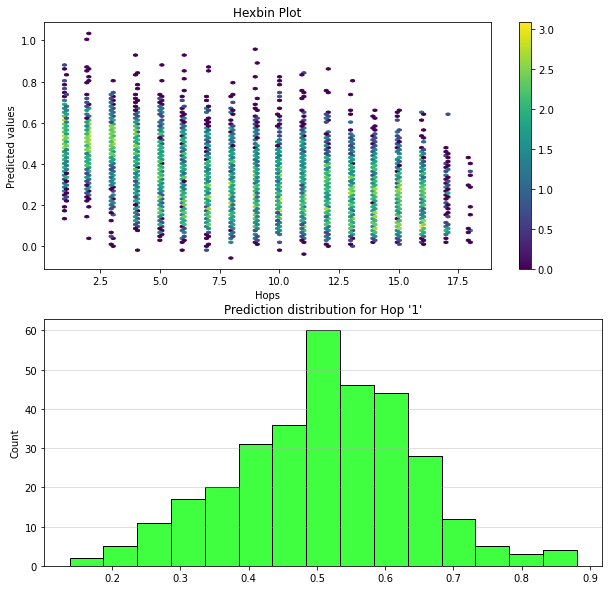

New best Validation! Saving weights...
Epoch 5


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01877
Batch  1000    Loss: 0.01870
Batch  1500    Loss: 0.01897


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.015895
Total Mean Squared Error: 0.0474
Total Mean Absolute Error: 0.1612

 Hop '1'	MAE: 0.3527, MSE: 0.1499
 Hop '2'	MAE: 0.1164, MSE: 0.0230
 Hop '3'	MAE: 0.1933, MSE: 0.0520
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	84.8958%
 Hops 2-3: 	60.1562%
 Hops 4-10: 	15.8482%
 Hops 11+: 	3.7178%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	39.2771%
Recall: 	84.8958%
Accuracy: 	89.1296%
f1: 	53.7068%
f1 Gain: 	92.4808%


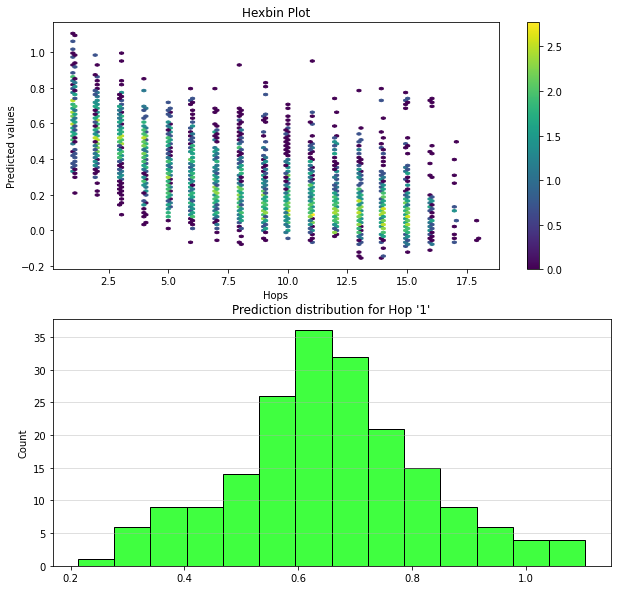

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022811
Total Mean Squared Error: 0.0749
Total Mean Absolute Error: 0.2186

 Hop '1'	MAE: 0.4774, MSE: 0.2465
 Hop '2'	MAE: 0.0981, MSE: 0.0166
 Hop '3'	MAE: 0.1708, MSE: 0.0386
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	58.0247%
 Hops 2-3: 	42.5926%
 Hops 4-10: 	20.4145%
 Hops 11+: 	12.2179%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	20.8889%
Recall: 	58.0247%
Accuracy: 	81.6847%
f1: 	30.7190%
f1 Gain: 	81.6493%


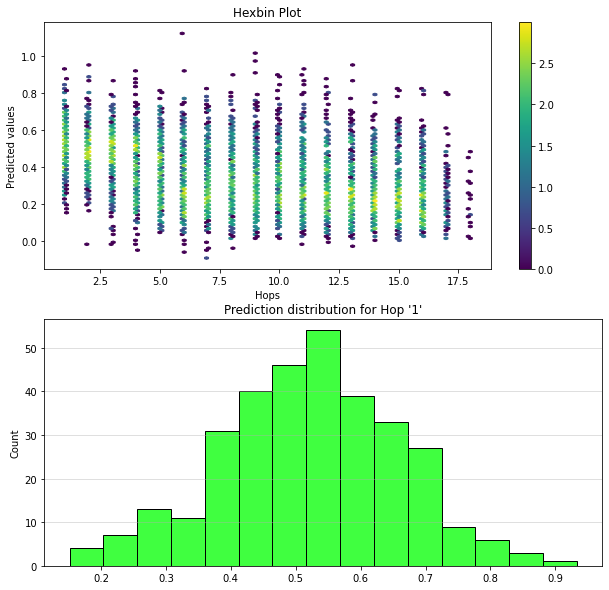

Epoch 6


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01840
Batch  1000    Loss: 0.01754
Batch  1500    Loss: 0.01795


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.015615
Total Mean Squared Error: 0.0365
Total Mean Absolute Error: 0.1424

 Hop '1'	MAE: 0.3960, MSE: 0.1741
 Hop '2'	MAE: 0.1019, MSE: 0.0167
 Hop '3'	MAE: 0.1728, MSE: 0.0391
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	79.1667%
 Hops 2-3: 	51.0417%
 Hops 4-10: 	9.0030%
 Hops 11+: 	1.0486%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	53.5211%
Recall: 	79.1667%
Accuracy: 	93.3462%
f1: 	63.8655%
f1 Gain: 	95.0644%


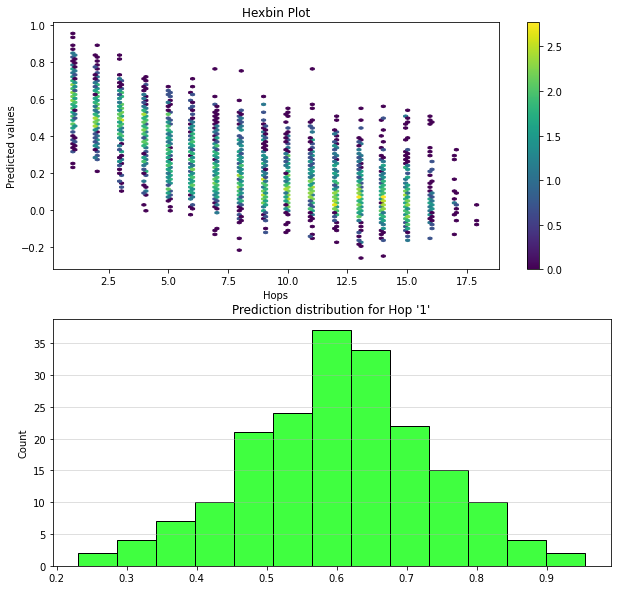

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023766
Total Mean Squared Error: 0.0580
Total Mean Absolute Error: 0.1873

 Hop '1'	MAE: 0.5318, MSE: 0.2991
 Hop '2'	MAE: 0.1006, MSE: 0.0176
 Hop '3'	MAE: 0.1494, MSE: 0.0296
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	41.3580%
 Hops 2-3: 	35.6481%
 Hops 4-10: 	11.1993%
 Hops 11+: 	3.4838%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	29.1939%
Recall: 	41.3580%
Accuracy: 	88.8769%
f1: 	34.2273%
f1 Gain: 	84.3643%


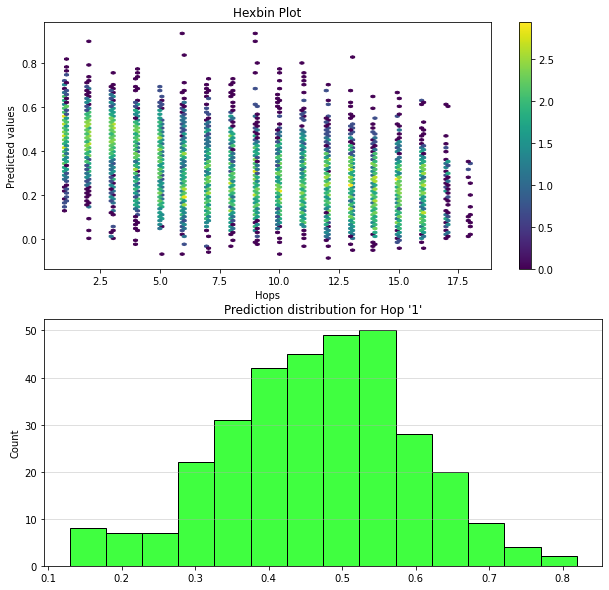

Epoch 7


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01799
Batch  1000    Loss: 0.01731
Batch  1500    Loss: 0.01707


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.015169
Total Mean Squared Error: 0.0385
Total Mean Absolute Error: 0.1490

 Hop '1'	MAE: 0.3574, MSE: 0.1529
 Hop '2'	MAE: 0.1312, MSE: 0.0285
 Hop '3'	MAE: 0.1916, MSE: 0.0503
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	82.8125%
 Hops 2-3: 	56.5104%
 Hops 4-10: 	10.5655%
 Hops 11+: 	1.4299%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	50.3165%
Recall: 	82.8125%
Accuracy: 	92.6499%
f1: 	62.5984%
f1 Gain: 	94.7880%


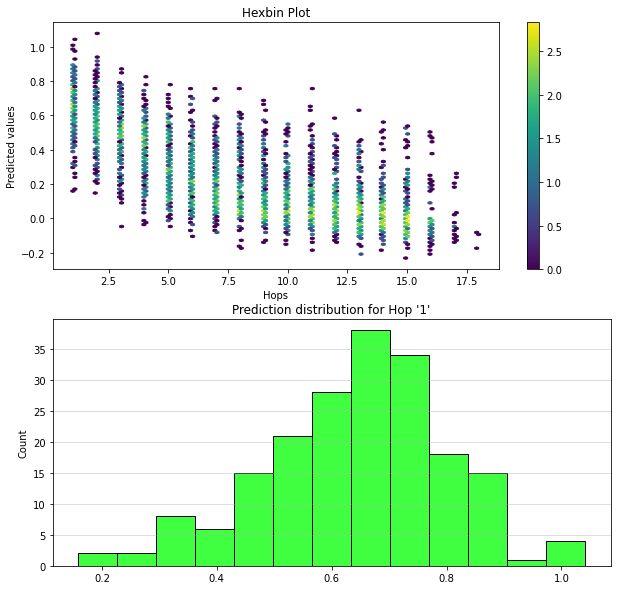

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023395
Total Mean Squared Error: 0.0599
Total Mean Absolute Error: 0.1867

 Hop '1'	MAE: 0.5052, MSE: 0.2797
 Hop '2'	MAE: 0.1243, MSE: 0.0254
 Hop '3'	MAE: 0.1657, MSE: 0.0377
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	48.4568%
 Hops 2-3: 	37.0370%
 Hops 4-10: 	14.1534%
 Hops 11+: 	4.4161%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	27.6408%
Recall: 	48.4568%
Accuracy: 	87.5162%
f1: 	35.2018%
f1 Gain: 	85.0224%


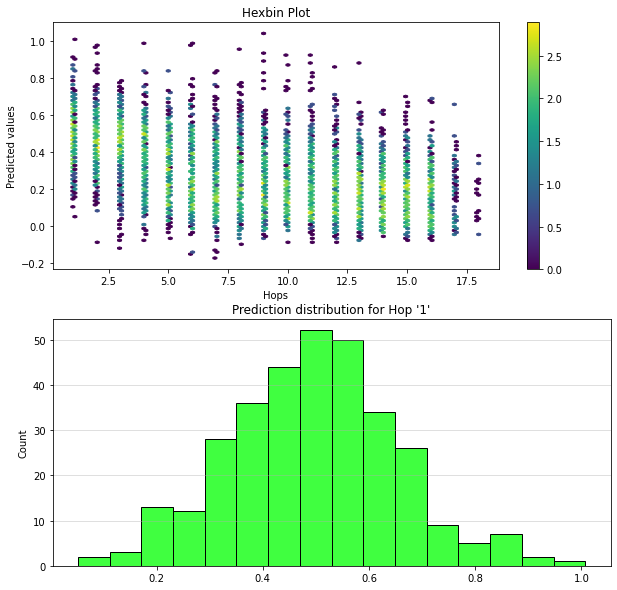

Epoch 8


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01672
Batch  1000    Loss: 0.01717
Batch  1500    Loss: 0.01676


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.013836
Total Mean Squared Error: 0.0432
Total Mean Absolute Error: 0.1607

 Hop '1'	MAE: 0.3061, MSE: 0.1119
 Hop '2'	MAE: 0.1337, MSE: 0.0281
 Hop '3'	MAE: 0.2236, MSE: 0.0637
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	90.6250%
 Hops 2-3: 	71.3542%
 Hops 4-10: 	16.5923%
 Hops 11+: 	1.4299%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	42.2330%
Recall: 	90.6250%
Accuracy: 	90.0967%
f1: 	57.6159%
f1 Gain: 	93.5829%


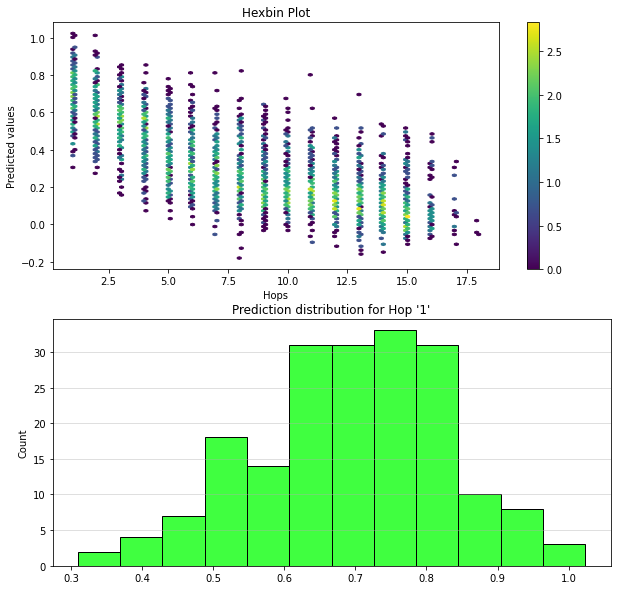

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022004
Total Mean Squared Error: 0.0741
Total Mean Absolute Error: 0.2297

 Hop '1'	MAE: 0.4552, MSE: 0.2257
 Hop '2'	MAE: 0.1068, MSE: 0.0188
 Hop '3'	MAE: 0.1938, MSE: 0.0495
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	65.1235%
 Hops 2-3: 	56.6358%
 Hops 4-10: 	21.6490%
 Hops 11+: 	7.0658%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	24.9409%
Recall: 	65.1235%
Accuracy: 	83.8445%
f1: 	36.0684%
f1 Gain: 	85.5778%


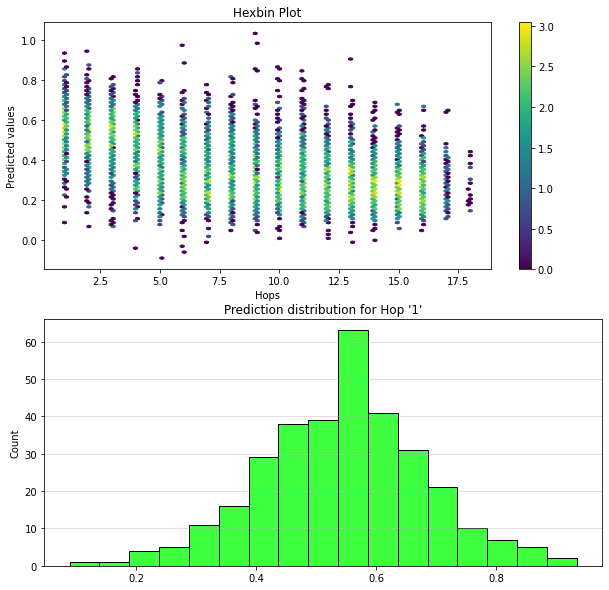

New best Validation! Saving weights...
Epoch 9


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01618
Batch  1000    Loss: 0.01619
Batch  1500    Loss: 0.01639


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.014057
Total Mean Squared Error: 0.0517
Total Mean Absolute Error: 0.1785

 Hop '1'	MAE: 0.2473, MSE: 0.0808
 Hop '2'	MAE: 0.1724, MSE: 0.0445
 Hop '3'	MAE: 0.2657, MSE: 0.0875
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	95.3125%
 Hops 2-3: 	80.7292%
 Hops 4-10: 	20.7589%
 Hops 11+: 	3.3365%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	36.8209%
Recall: 	95.3125%
Accuracy: 	87.5048%
f1: 	53.1205%
f1 Gain: 	92.3016%


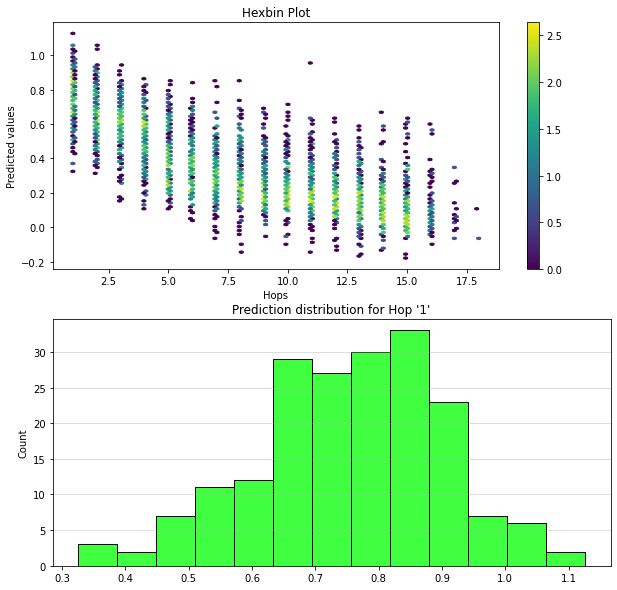

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022356
Total Mean Squared Error: 0.0886
Total Mean Absolute Error: 0.2540

 Hop '1'	MAE: 0.4124, MSE: 0.1934
 Hop '2'	MAE: 0.1254, MSE: 0.0251
 Hop '3'	MAE: 0.2315, MSE: 0.0696
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	73.4568%
 Hops 2-3: 	67.2840%
 Hops 4-10: 	28.3069%
 Hops 11+: 	13.5427%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	20.5882%
Recall: 	73.4568%
Accuracy: 	78.3153%
f1: 	32.1622%
f1 Gain: 	82.8379%


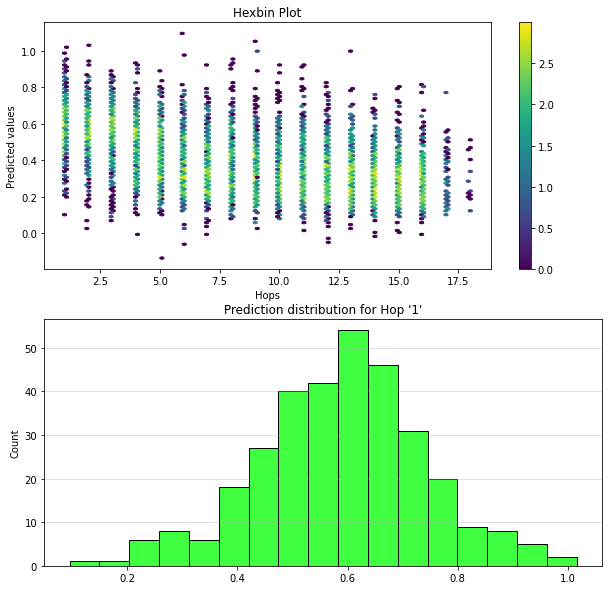

Epoch 10


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01556
Batch  1000    Loss: 0.01580
Batch  1500    Loss: 0.01609


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.013228
Total Mean Squared Error: 0.0478
Total Mean Absolute Error: 0.1641

 Hop '1'	MAE: 0.2455, MSE: 0.0830
 Hop '2'	MAE: 0.1598, MSE: 0.0399
 Hop '3'	MAE: 0.2397, MSE: 0.0749
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	93.2292%
 Hops 2-3: 	75.5208%
 Hops 4-10: 	18.8988%
 Hops 11+: 	3.7178%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	37.9237%
Recall: 	93.2292%
Accuracy: 	88.1625%
f1: 	53.9157%
f1 Gain: 	92.5438%


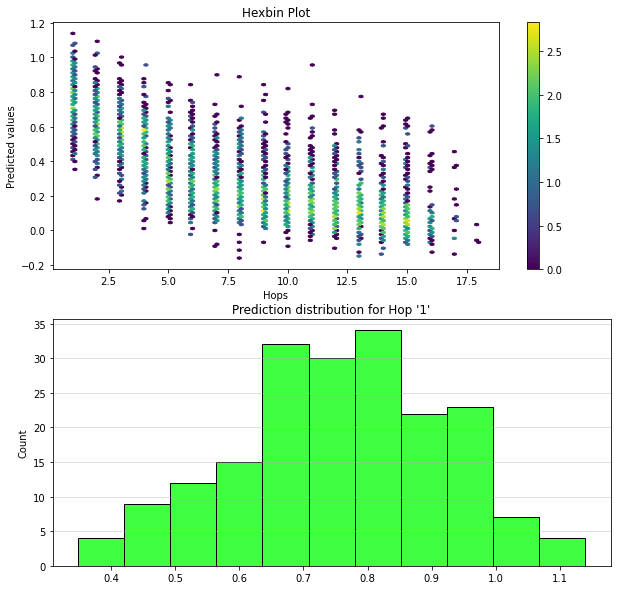

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022326
Total Mean Squared Error: 0.0862
Total Mean Absolute Error: 0.2429

 Hop '1'	MAE: 0.4206, MSE: 0.2015
 Hop '2'	MAE: 0.1213, MSE: 0.0248
 Hop '3'	MAE: 0.2175, MSE: 0.0624
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	71.6049%
 Hops 2-3: 	60.3395%
 Hops 4-10: 	25.4409%
 Hops 11+: 	13.2483%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	21.5014%
Recall: 	71.6049%
Accuracy: 	79.7192%
f1: 	33.0720%
f1 Gain: 	83.5339%


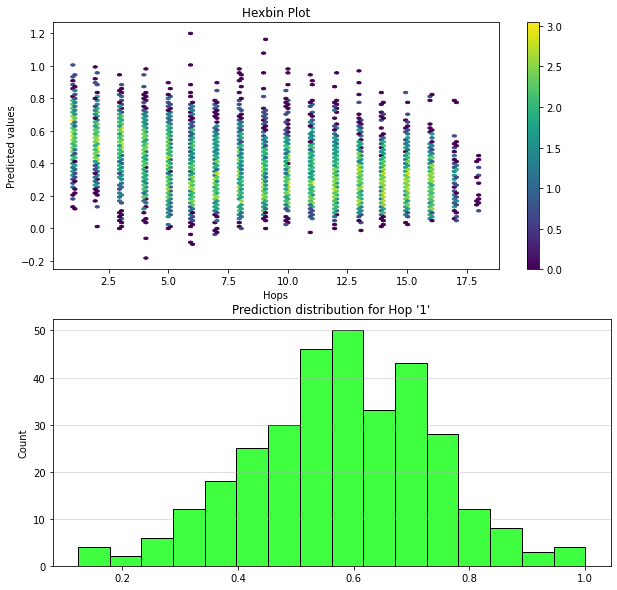

Epoch 11


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01532
Batch  1000    Loss: 0.01503
Batch  1500    Loss: 0.01590


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.012927
Total Mean Squared Error: 0.0331
Total Mean Absolute Error: 0.1342

 Hop '1'	MAE: 0.3358, MSE: 0.1329
 Hop '2'	MAE: 0.1104, MSE: 0.0205
 Hop '3'	MAE: 0.1588, MSE: 0.0369
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	85.9375%
 Hops 2-3: 	49.2188%
 Hops 4-10: 	8.4077%
 Hops 11+: 	1.2393%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	56.7010%
Recall: 	85.9375%
Accuracy: 	94.0812%
f1: 	68.3230%
f1 Gain: 	95.9556%


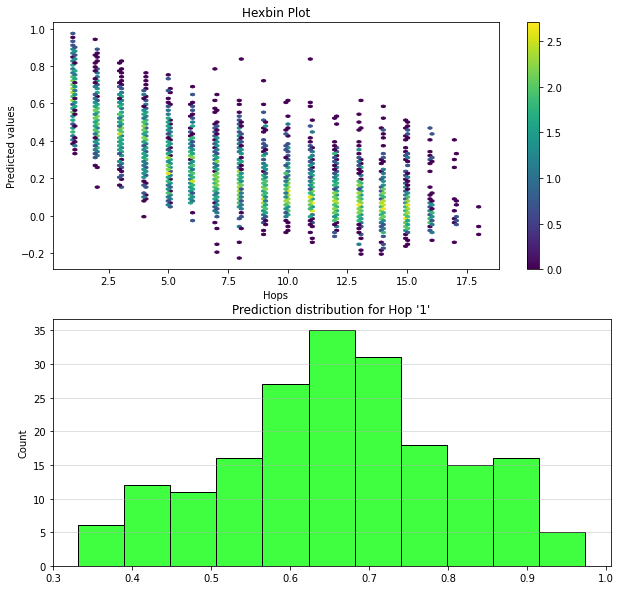

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023076
Total Mean Squared Error: 0.0619
Total Mean Absolute Error: 0.1943

 Hop '1'	MAE: 0.5024, MSE: 0.2761
 Hop '2'	MAE: 0.1121, MSE: 0.0207
 Hop '3'	MAE: 0.1525, MSE: 0.0328
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	51.2346%
 Hops 2-3: 	34.7222%
 Hops 4-10: 	12.3457%
 Hops 11+: 	5.2012%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	30.0725%
Recall: 	51.2346%
Accuracy: 	88.2505%
f1: 	37.8995%
f1 Gain: 	86.6677%


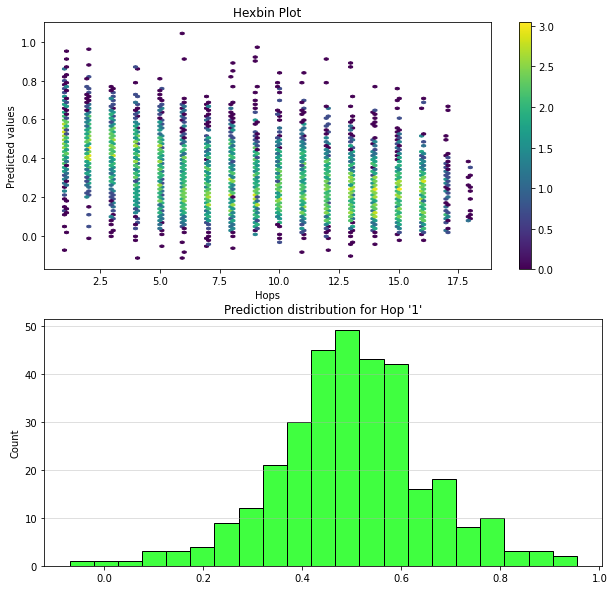

Epoch 12


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01502
Batch  1000    Loss: 0.01566
Batch  1500    Loss: 0.01421


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.012839
Total Mean Squared Error: 0.0318
Total Mean Absolute Error: 0.1307

 Hop '1'	MAE: 0.3372, MSE: 0.1338
 Hop '2'	MAE: 0.1181, MSE: 0.0217
 Hop '3'	MAE: 0.1556, MSE: 0.0350
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	83.8542%
 Hops 2-3: 	47.3958%
 Hops 4-10: 	8.5565%
 Hops 11+: 	0.6673%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	56.8905%
Recall: 	83.8542%
Accuracy: 	94.0812%
f1: 	67.7895%
f1 Gain: 	95.8551%


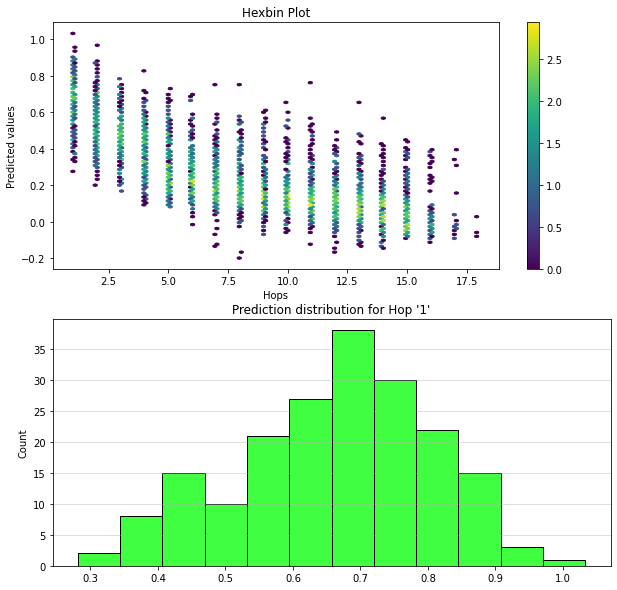

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.023183
Total Mean Squared Error: 0.0607
Total Mean Absolute Error: 0.1913

 Hop '1'	MAE: 0.5089, MSE: 0.2812
 Hop '2'	MAE: 0.1211, MSE: 0.0230
 Hop '3'	MAE: 0.1469, MSE: 0.0308
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	47.2222%
 Hops 2-3: 	34.1049%
 Hops 4-10: 	12.5220%
 Hops 11+: 	5.3974%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	27.9707%
Recall: 	47.2222%
Accuracy: 	87.7970%
f1: 	35.1320%
f1 Gain: 	84.9765%


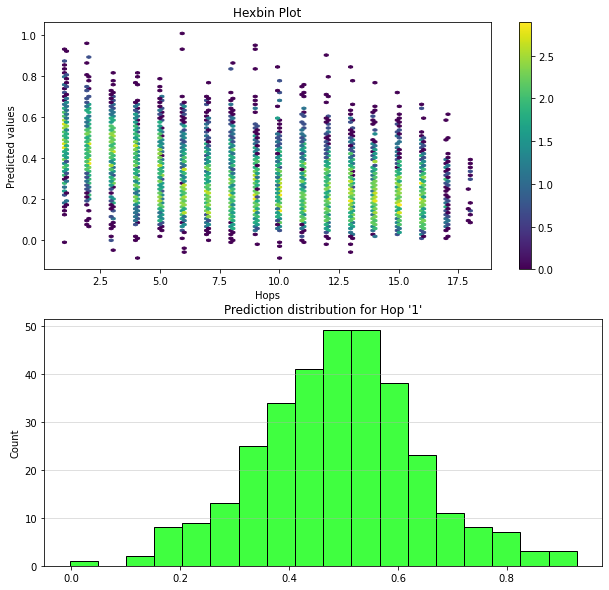

Epoch 13


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01455
Batch  1000    Loss: 0.01493
Batch  1500    Loss: 0.01425


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.011956
Total Mean Squared Error: 0.0392
Total Mean Absolute Error: 0.1468

 Hop '1'	MAE: 0.2548, MSE: 0.0864
 Hop '2'	MAE: 0.1479, MSE: 0.0364
 Hop '3'	MAE: 0.2109, MSE: 0.0616
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	93.7500%
 Hops 2-3: 	67.1875%
 Hops 4-10: 	12.7976%
 Hops 11+: 	3.1459%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	46.7532%
Recall: 	93.7500%
Accuracy: 	91.6054%
f1: 	62.3917%
f1 Gain: 	94.7418%


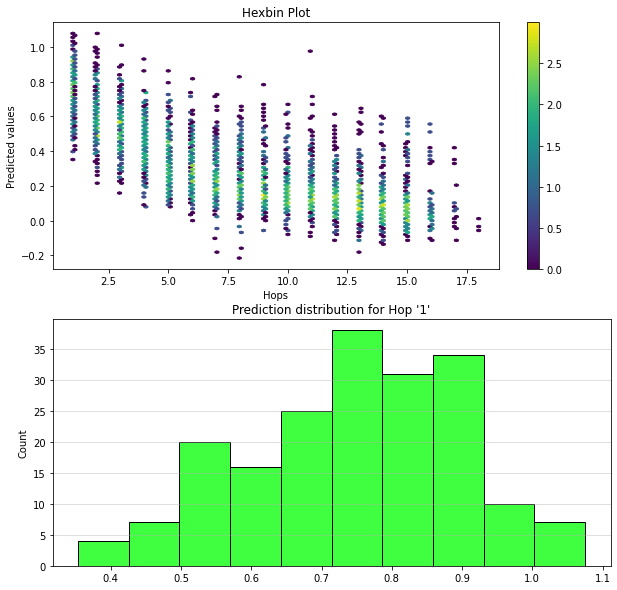

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022811
Total Mean Squared Error: 0.0808
Total Mean Absolute Error: 0.2343

 Hop '1'	MAE: 0.4463, MSE: 0.2275
 Hop '2'	MAE: 0.1231, MSE: 0.0252
 Hop '3'	MAE: 0.1929, MSE: 0.0518
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	63.5802%
 Hops 2-3: 	50.6173%
 Hops 4-10: 	20.7231%
 Hops 11+: 	11.8253%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	22.4646%
Recall: 	63.5802%
Accuracy: 	82.0950%
f1: 	33.1990%
f1 Gain: 	83.6280%


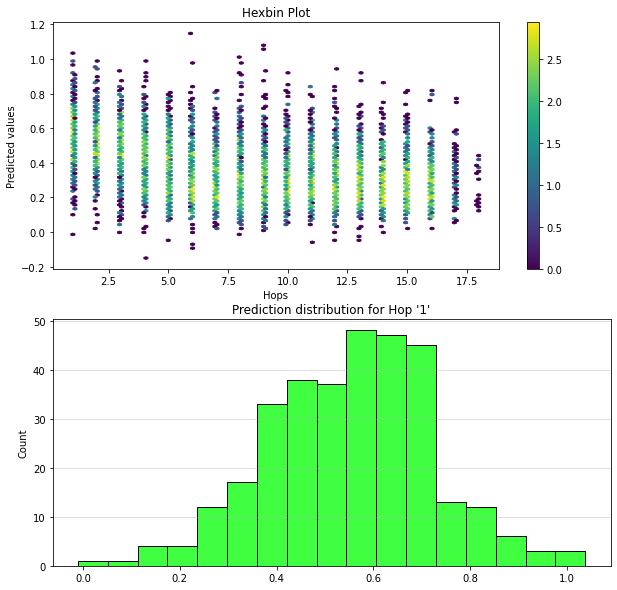

Epoch 14


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01447
Batch  1000    Loss: 0.01411
Batch  1500    Loss: 0.01447


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.011866
Total Mean Squared Error: 0.0345
Total Mean Absolute Error: 0.1374

 Hop '1'	MAE: 0.2852, MSE: 0.1054
 Hop '2'	MAE: 0.1290, MSE: 0.0269
 Hop '3'	MAE: 0.1793, MSE: 0.0463
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	88.0208%
 Hops 2-3: 	58.0729%
 Hops 4-10: 	10.1935%
 Hops 11+: 	1.9066%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	51.8405%
Recall: 	88.0208%
Accuracy: 	93.0368%
f1: 	65.2510%
f1 Gain: 	95.3545%


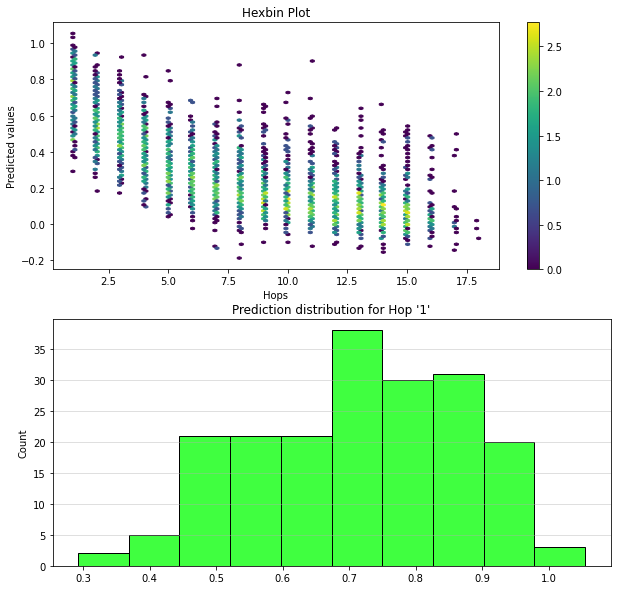

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022639
Total Mean Squared Error: 0.0704
Total Mean Absolute Error: 0.2091

 Hop '1'	MAE: 0.4722, MSE: 0.2500
 Hop '2'	MAE: 0.1149, MSE: 0.0226
 Hop '3'	MAE: 0.1672, MSE: 0.0408
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	57.4074%
 Hops 2-3: 	41.5123%
 Hops 4-10: 	15.6966%
 Hops 11+: 	8.7341%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	25.8333%
Recall: 	57.4074%
Accuracy: 	85.4860%
f1: 	35.6322%
f1 Gain: 	85.3016%


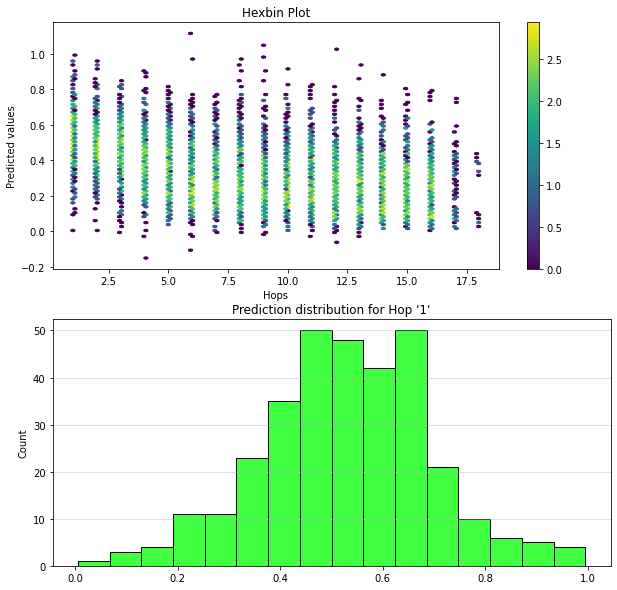

Epoch 15


  0%|          | 0/1711 [00:00<?, ?it/s]

Batch   500    Loss: 0.01381
Batch  1000    Loss: 0.01371
Batch  1500    Loss: 0.01453


  0%|          | 0/2969 [00:00<?, ?it/s]


Test Results:
Loss: 0.011321
Total Mean Squared Error: 0.0384
Total Mean Absolute Error: 0.1454

 Hop '1'	MAE: 0.2322, MSE: 0.0752
 Hop '2'	MAE: 0.1495, MSE: 0.0358
 Hop '3'	MAE: 0.2090, MSE: 0.0610
0.08023401587964897

Percentage of prediction > 0.5: 
 Hop  1: 	94.2708%
 Hops 2-3: 	66.9271%
 Hops 4-10: 	14.8810%
 Hops 11+: 	1.2393%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	45.9391%
Recall: 	94.2708%
Accuracy: 	91.3346%
f1: 	61.7747%
f1 Gain: 	94.6022%


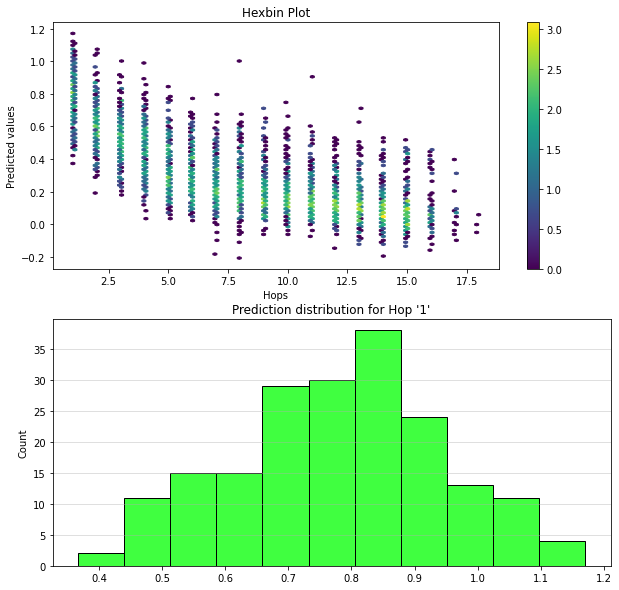

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
Loss: 0.022575
Total Mean Squared Error: 0.0798
Total Mean Absolute Error: 0.2302

 Hop '1'	MAE: 0.4363, MSE: 0.2210
 Hop '2'	MAE: 0.1249, MSE: 0.0259
 Hop '3'	MAE: 0.1972, MSE: 0.0542
0.07524384579656293

Percentage of prediction > 0.5: 
 Hop  1: 	66.6667%
 Hops 2-3: 	51.8519%
 Hops 4-10: 	21.6490%
 Hops 11+: 	10.6968%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	23.3514%
Recall: 	66.6667%
Accuracy: 	82.3542%
f1: 	34.5877%
f1 Gain: 	84.6120%


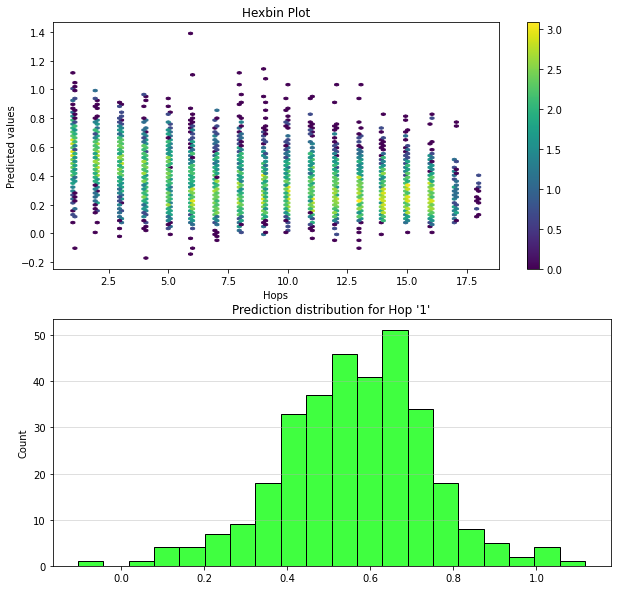

Finished Training
8


In [11]:
from torchmetrics import MeanAbsolutePercentageError

# Custom loss function
def custom_loss(output, target):
#     loss = torch.mean(((output - target)**2)) # MSE
#     loss = torch.mean(((output - target)**2)*(target+0.01/target)) # More attention to low hops
    loss = torch.mean(((output - target)**2)*target)
    return loss

def save_for_best_loss(metrics):
    return metrics["loss"]

# Hyper parameters
epochs = 15
LR = 2e-4
BSZ = 32
# criterion = MeanAbsolutePercentageError().to('cpu')
criterion = custom_loss
model = NeuralNetwork()
# model = ConvNetwork()
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.RMSprop(model.parameters(), lr=LR)
# print(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Data Loaders
train_loader = DataLoader(tuple(zip(x_train,y_train)), batch_size=BSZ, shuffle=True)
sub_train_loader = DataLoader(tuple(zip(x_sub_train,y_sub_train)), batch_size=1, shuffle=True)
valid_loader = DataLoader(tuple(zip(x_valid,y_valid)), batch_size=1, shuffle=True)

# Train and Test(sub-test)
_,stopping_epoch = AIO(model, FE_inputs, train_loader, valid_loader, epochs, criterion, optimizer, scheduler,'PubMedBERT', save_criterion_func = save_for_best_loss, train_loader2 = sub_train_loader)
print(stopping_epoch)

# Final Tests

Test trained model on balanced test set - no common nodes with train


  0%|          | 0/98779 [00:00<?, ?it/s]


Test Results:
Loss: 0.023395
Total Mean Squared Error: 0.0740
Total Mean Absolute Error: 0.2276

 Hop '1'	MAE: 0.4533, MSE: 0.2239
 Hop '2'	MAE: 0.1082, MSE: 0.0184
 Hop '3'	MAE: 0.1800, MSE: 0.0445
0.08304715530497181

Percentage of prediction > 0.5: 
 Hop  1: 	65.8540%
 Hops 2-3: 	54.3625%
 Hops 4-10: 	21.6280%
 Hops 11+: 	8.3058%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	24.5316%
Recall: 	65.8540%
Accuracy: 	81.8471%
f1: 	35.7469%
f1 Gain: 	83.7208%


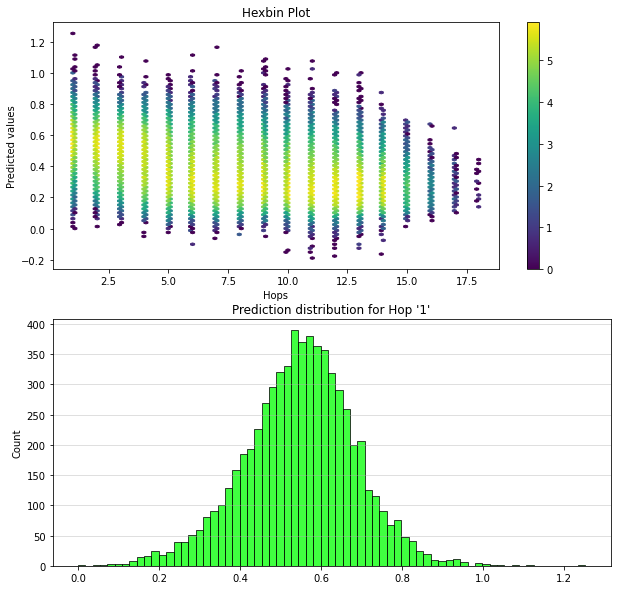

In [12]:
# Loader for final testing (balanced)
test_balanced_loader = DataLoader(tuple(zip(x_test_balanced,y_test_balanced)), batch_size=1, shuffle=True)

# Load Best version for testing
model_PMB = torch.load("./PubMedBERT/Model.pth")#, map_location=torch.device('cpu'))
model_PMB.eval()
print("Test trained model on balanced test set - no common nodes with train")
balanced_test_metrics = test_model(model_PMB, FE_inputs, test_balanced_loader, criterion)

Test model on all original train data


  0%|          | 0/54739 [00:00<?, ?it/s]


Test Results:
Loss: 0.015509
Total Mean Squared Error: 0.0474
Total Mean Absolute Error: 0.1718

 Hop '1'	MAE: 0.3048, MSE: 0.1121
 Hop '2'	MAE: 0.1355, MSE: 0.0275
 Hop '3'	MAE: 0.2153, MSE: 0.0602
0.09057706355003653

Percentage of prediction > 0.5: 
 Hop  1: 	92.2737%
 Hops 2-3: 	70.0568%
 Hops 4-10: 	17.4584%
 Hops 11+: 	1.9310%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	39.5782%
Recall: 	92.2737%
Accuracy: 	87.6585%
f1: 	55.3959%
f1 Gain: 	91.9805%


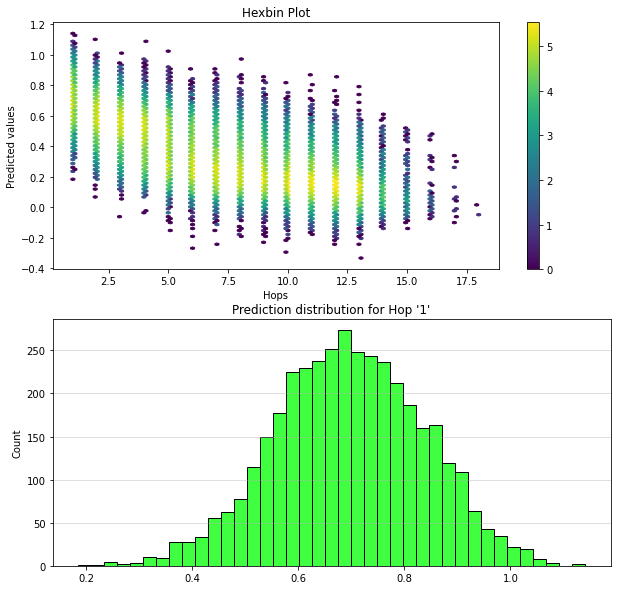

In [13]:
print("Test model on all original train data")
train_loader_for_testing = DataLoader(tuple(zip(x_train,y_train)), batch_size=1, shuffle=True)
balanced_train_metrics = test_model(model_PMB, FE_inputs, train_loader_for_testing, criterion)

In [ ]:
print("Test model on all distant pairs") 
data_dis = pd.read_csv('Distant pairs Undirected.csv', header=0)
data_dis = data_dis[data_dis["Hops"]>11] # >11 to reduce time

data_dis["Hops"] = y_transform(data_dis["Hops"])
y_test_dis = pd.to_numeric(data_dis.Hops)#.astype(int)
x_test_dis = np.vectorize(joining)(data_dis.Head.astype(str),data_dis.Tail.astype(str))

distant_loader = DataLoader(tuple(zip(x_test_dis,y_test_dis)), batch_size=1, shuffle=True)
distant_pairs_metrics = test_model(model_PMB, FE_inputs, distant_loader, criterion)

In [ ]:
# temp = pd.DataFrame([last_epoch, balanced_test_metrics, balanced_train_metrics, distant_pairs_metrics])
# temp.to_csv('testout.csv')